Using TensorFlow backend.


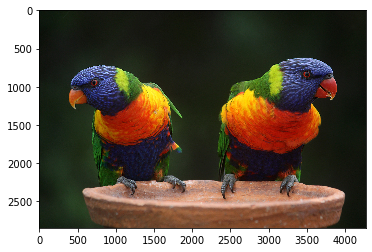

In [ ]:
from __future__ import print_function, division

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AvgPool2D, MaxPooling2D
from keras.layers import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b
from datetime import datetime


# In VGG16 pre trained model we use max pooling
# we want to change it to average pooling 2D
def VGG16_AvgPool(sh):
    # we want to account for features across the entire image
    # so get rid of the maxpool which throws away information
    vgg = VGG16(input_shape=sh, weights='imagenet', include_top=False)

    new_model = Sequential()
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            # replace it with average pooling
            new_model.add(AvgPool2D())
        else:
            new_model.add(layer)

    return new_model


# Create a partial model to compare the output at an intermediate
# convolution, hence this function allows us to specify how many
# convolution to include.
# VGG16 has 13 convolutions so we check if there are 13.

def VGG16_AvgPool_CutOff(s, num_convs):
    # there are 13 convolutions in total
    # we can pick any of them as the "output"
    # of our content model

    if num_convs < 1 or num_convs > 13:
        print("num_convs must be in the range [1, 13]")
        return None

    model = VGG16_AvgPool(s)
    new_model = Sequential()
    n = 0
    for layer in model.layers:
        if layer.__class__ == Conv2D:
            n += 1
        new_model.add(layer)
        if n >= num_convs:
            break

    return new_model


def unpreprocess(img_t):
    img_t[..., 0] += 103.939
    img_t[..., 1] += 116.779
    img_t[..., 2] += 126.68
    return img_t


# Output pixel intensities between 0 ~ 1
def scale_img(x_t):
    x_t = x_t - x_t.min()
    x_t = x_t / x_t.max()
    return x_t


if __name__ == '__main__':
    path = r'C:\Users\aayus\Desktop\NeuralStyleTransfer\blue-green-and-orange-parrot-37833.jpg'  # Open image
    img = image.load_img(path)  # Load using keras.preprocessing.image

    # Convert the image to array and pre process for vgg
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    batch_shape = x.shape  # 4-Dimensions
    b_s = batch_shape
    shape = x.shape[1:]  # W x H x C

    # see the image
    plt.imshow(img)
    plt.show()

    content_model = VGG16_AvgPool_CutOff(shape, 11)  # For some other network num_convs can be different

    # Make the target so we have the Y output for image X
    target = K.variable(content_model.predict(x))
    loss = K.mean(K.square(target - content_model.output))  # L = mean((Y - Y_prime) **2)

    # Gradients needed by optimiser
    grads = K.gradients(loss, content_model.output)

    get_loss_and_grads = K.function(
        inputs=[content_model.input],
        outputs=[loss] + grads
    )


def get_loss_and_grads_wrapper(x_vec):
    # scipy's minimizer allows us to pass back
    # function value f(x) and its gradient f'(x)
    # simultaneously, rather than using the fprime arg
    #
    # we cannot use get_loss_and_grads() directly
    # input to minimizer func must be a 1-D array
    # input to get_loss_and_grads must be [batch_of_images]
    #
    # gradient must also be a 1-D array
    # and both loss and gradient must be np.float64
    # will get an error otherwise

    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)


t0 = datetime.now()
losses = []
x = np.random.randn(np.prod(batch_shape))
for i in range(10):
    x, l, _ = fmin_l_bfgs_b(
        func=get_loss_and_grads_wrapper,
        x0=x,
        # bounds=[[-127, 127]]*len(x.flatten()),
        maxfun=20
    )
    x = np.clip(x, -127, 127)
    # print("min:", x.min(), "max:", x.max())
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

print("duration:", datetime.now() - t0)
plt.plot(losses)
plt.show()

new_img = x.reshape(*batch_shape)
final_img = unpreprocess(newimg)

plt.imshow(scale_img(final_img[0]))
plt.show()
